#  Investigating Ground Subsidence Across Surface Features in the Yukon River Delta
## Charles McGrath

<img src="Permafrost.jpg" width="600">
Permafrost <br>
Source: NRDC

### Read in and Reprojecting Data

In [1]:
from osgeo import gdal
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
from pyproj import Transformer


In [2]:
# Import data

file_paths = glob.glob("data/*")

data_files = []  # List to store data files
data_bands = []  # Stores data bands
data_arrs = []   # Stores data arrays
crs = []  # Stores coordinate systems

for file in file_paths:
    file_open = gdal.Open(file)
    crs.append(file_open.GetProjection())
    data_files.append(file_open)
    data_band = file_open.GetRasterBand(1)
    data_bands.append(data_band)
    data_arr = data_band.ReadAsArray()
    data_arr = np.nan_to_num(data_arr,nan=0)
    data_arrs.append(data_arr)
    
land_cover= gdal.Open('NLCD_2016_Land_Cover_AK_20200724.img')
dtm = gdal.Open('DTM_5m_wgs84.tif')

In [3]:
# Crop each layer to specified extent


reproj_files = ['reproj_thaw_subsidence.tif','reproj_cumulative_sub.tif',  # Input raster files
                'reproj_thaw_rate.tif','reproj_alt.tif','reproj_deformation.tif']
output_files = ['thaw_subsidence_output.tif','cumulative_sub_output.tif',  # Output raster files
                'thaw_rate_output.tif','alt_output.tif','deformation_output.tif']
cropped_files = []
cropped_bands = []
cropped_arrays = []
crop_extent = [-161.94, 60.83, -161.669, 60.748]

for index,value in enumerate(reproj_files):  # Loop through each input raster file
    gdal.Translate(output_files[index],data_files[index],projWin=crop_extent)  # Crop files
    cropped_file = gdal.Open(output_files[index])
    cropped_files.append(cropped_file)
    cropped_band = cropped_file.GetRasterBand(1)
    cropped_bands.append(cropped_band)
    cropped_arr = cropped_band.ReadAsArray()
    cropped_arrays.append(cropped_arr)

In [4]:
# Crop elevation dataset separately

reprojected_dtm = 'dtm_reproj.tif'
translated_dtm = 'translated_dtm.tif'
gdal.Translate(translated_dtm, dtm,projWin=crop_extent)

gdal.Warp(reprojected_dtm,translated_dtm, dstSRS='EPSG:32604',resampleAlg='bilinear')
dtm_dataset = gdal.Open(reprojected_dtm)

In [5]:
# Convert coordinates of extent to easting and northing to match land cover coordinate projection

source_crs = "EPSG:4326"  # Define the source CRS (WGS84 Latitude/Longitude)
target_crs = land_cover.GetProjection() # Define the target CRS (WGS 1984 Albers)
transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True) # Create a transformer
crop_extent = [-161.94, 60.83, -161.669, 60.748]  # Define crop extent
easting, northing = transformer.transform(crop_extent[0],crop_extent[1]) # Convert to WGS 1984 Albers (easting, northing)
easting1, northing1 = transformer.transform(crop_extent[2],crop_extent[3])
lc_extent=[easting,northing,easting1,northing1] # Create list of coordinates

In [6]:
# Crop land cover data to desired extent

land_cover_file = 'land_cover.tif' 
gdal.Translate(land_cover_file, land_cover,projWin=lc_extent) 
lc_cropped = gdal.Open(land_cover_file)
lc_band1 = lc_cropped.GetRasterBand(1)
lc_arr = lc_band1.ReadAsArray()

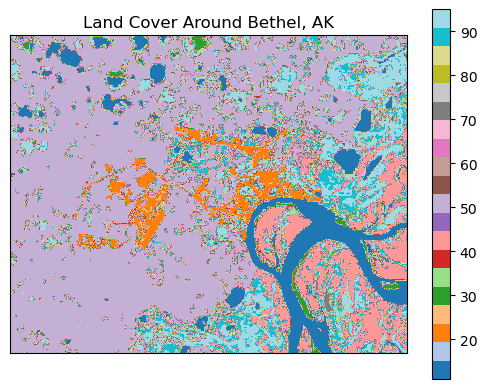

In [7]:
# Plot land cover types

plt.imshow(lc_arr,cmap='tab20')
plt.title('Land Cover Around Bethel, AK')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Resampling the Data

In [9]:
# Resample each data source to match land cover types

output_raster = ['thaw_sub_resampled.tif','cumulative_sub_resampled.tif',  # Define output raster files
                 'thaw_rate_resampled.tif','alt_resampled.tif',
                 'deformation_resampled.tif','dtm_resampled.tif'
                 ]
read_files = {}  # Create empty dictionaries that will store raster datasets, bands, and image arrays
bands = {}
arrays = {}
reference_raster = lc_cropped  # Assign reference raster as land cover dataset
ref_cols = reference_raster.RasterXSize  # Define reference columns and rows
ref_rows = reference_raster.RasterYSize
cropped_files.append(reprojected_dtm)
input_raster = cropped_files  # Set input raster as each cropped raster dataset
for x,y in zip(output_raster,input_raster):  # Loop through each input and output raster 
    gdal.Warp(x, y,  # Reproject input raster using bilinear interpolation to match shape of land cover dataset
        width=ref_cols, 
        height=ref_rows, 
        resampleAlg=gdal.GRA_Bilinear)  
    read_file = gdal.Open(x)  # Open dataset and add to files list
    read_files[x]=read_file
    band1 = read_file.GetRasterBand(1)  # Get the raster band and add to bands list
    bands[x]=band1
    read_arr = band1.ReadAsArray()  # Read as array and add to arrays list
    arrays[x]=read_arr

In [11]:
# Resample dtm image separately to avoid errors 

reference_raster = lc_cropped
ref_cols = reference_raster.RasterXSize
ref_rows = reference_raster.RasterYSize
input_raster = reprojected_dtm
output_raster = 'dtm_resampled.tif'
gdal.Warp(output_raster, input_raster, 
          width=ref_cols, 
          height=ref_rows, 
          resampleAlg=gdal.GRA_Bilinear)  # Bilinear resampling
dtm_re = gdal.Open(output_raster)
dtm_resampled_band = dtm_re.GetRasterBand(1)
dtm_arr = dtm_resampled_band.ReadAsArray()

In [12]:
# Create new dictionary with zeros as nan values 

clean_data = {
    key: np.where(value < -100, np.nan, value)  
    for key, value in arrays.items()
}

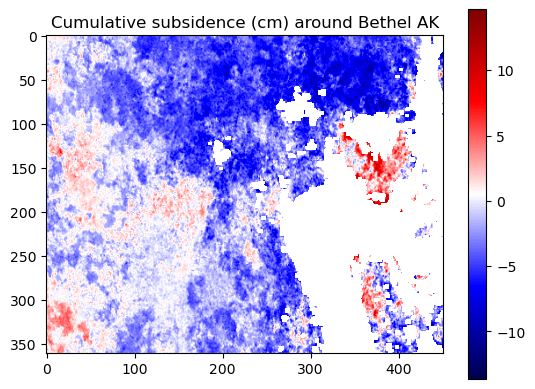

In [13]:
plt.imshow(arrays['cumulative_sub_resampled.tif'],cmap='seismic')
plt.colorbar()
plt.title('Cumulative subsidence (cm) around Bethel AK')
plt.show()

# Calculating slope, aspect, and hillshade

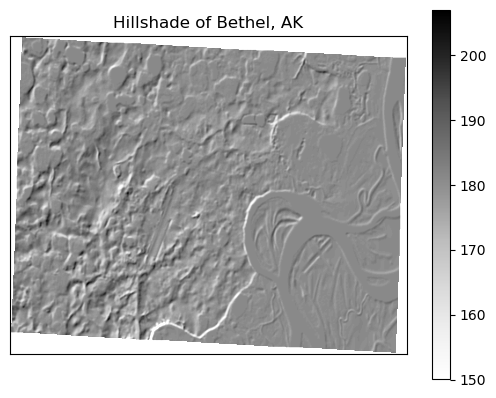

In [14]:
# Calculate and plot hillshade using resampled dtm

hillshade = gdal.DEMProcessing('hillshade.tif',dtm_re,'hillshade')
hillshade_band1 = hillshade.GetRasterBand(1)
hillshade_arr = hillshade_band1.ReadAsArray()
plt.imshow(hillshade_arr,cmap='Greys',vmin=150)
plt.title('Hillshade of Bethel, AK')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

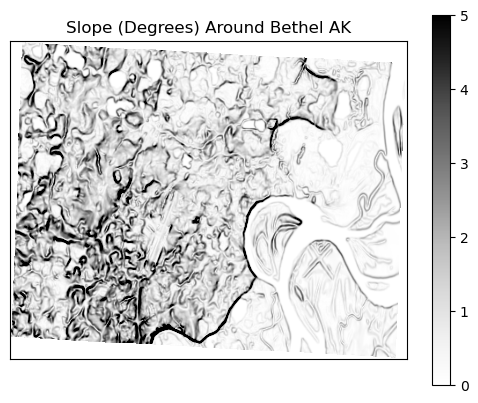

In [15]:
# Calculate and plot slope

slope = gdal.DEMProcessing('slope.tif',dtm_re,'slope',slopeFormat='degree')
slope_band1 = slope.GetRasterBand(1)
slope_arr = slope_band1.ReadAsArray()
slope_arr[np.where(slope_arr==-9999)]=np.nan
plt.imshow(slope_arr,cmap='Greys',vmin=0,vmax=5)
plt.title('Slope (Degrees) Around Bethel AK')
plt.xticks([])
plt.yticks([])
plt.colorbar()

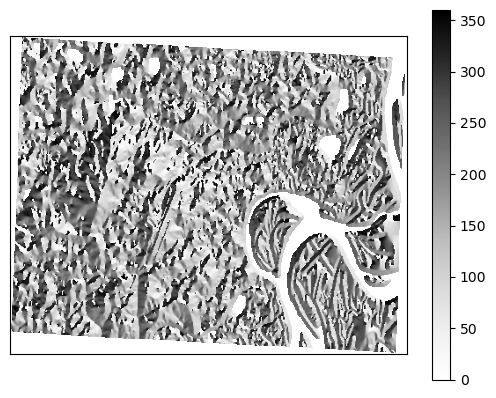

In [16]:
# Calculate and plot aspect

aspect = gdal.DEMProcessing('aspect.tif',dtm_re,'aspect')
aspect_band1 = aspect.GetRasterBand(1)
aspect_arr = aspect_band1.ReadAsArray()
plt.imshow(aspect_arr,cmap='Greys',vmin=0, vmax=360)
plt.xticks([])
plt.yticks([])
plt.colorbar()

### Mapping deformation and slope per land cover types

In [38]:
# Create copies of each resampled raster layer

alt_copy = np.copy(clean_data['alt_resampled.tif'])
thaw_copy = np.copy(clean_data['thaw_sub_resampled.tif'])
thaw_rate_copy = np.copy(clean_data['thaw_rate_resampled.tif'])
cumulative_sub_copy = np.copy(clean_data['cumulative_sub_resampled.tif'])
def_copy = np.copy(clean_data['deformation_resampled.tif'])
slope_copy = np.copy(dtm_arr)

In [18]:
# Create copies of each layer and select pixels within urban areas

alt_urban = np.copy(alt_copy)
thaw_urban = np.copy(thaw_copy)
cumulative_urban = np.copy(cumulative_sub_copy)

for index,value in enumerate(lc_arr):  # Loop through land cover raster
    for i,v in enumerate(lc_arr[index]):
        if v<21 or v>24:  # Select pixels from raster layers that are not within urban areas in land cover layer
            alt_urban[index][i]=np.nan
            thaw_urban[index][i]=np.nan
            cumulative_urban[index][i]=np.nan

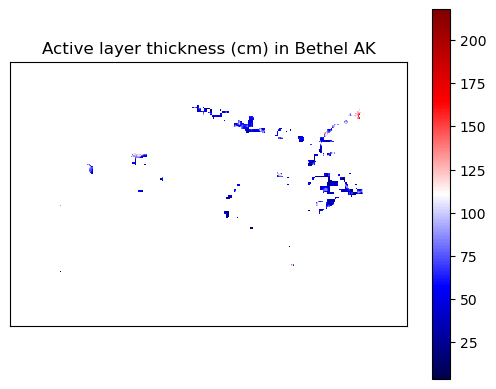

In [19]:
# Plot active layer thickness in Bethel AK

plt.imshow(alt_urban[70:270,50:350],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Active layer thickness (cm) in Bethel AK')
plt.show()

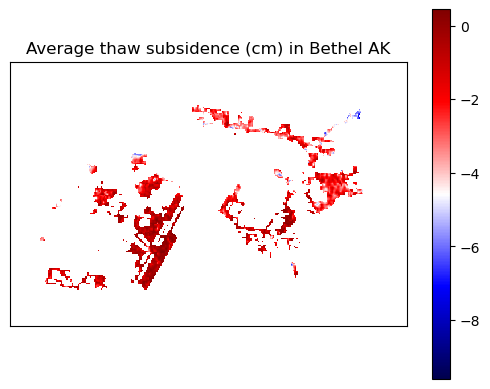

In [20]:
# Plot average thaw subsidence in Bethel AK

plt.imshow(thaw_urban[70:270,50:350],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Average thaw subsidence (cm) in Bethel AK')
plt.show()

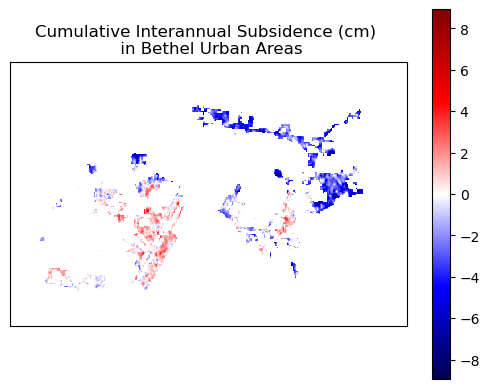

In [21]:
# Plot cumulative thaw subsidence in Bethel AK

plt.imshow(cumulative_urban[70:270,50:350],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Cumulative Interannual Subsidence (cm) \n in Bethel Urban Areas')
plt.show()

In [22]:
# Create copies of each layer and select pixels within areas marked by scrubland

cumulative_scrub = np.copy(cumulative_sub_copy)
alt_scrub = np.copy(alt_copy)
for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v<51 or v>52:
            cumulative_scrub[index][i]=np.nan
            alt_scrub[index][i]=np.nan

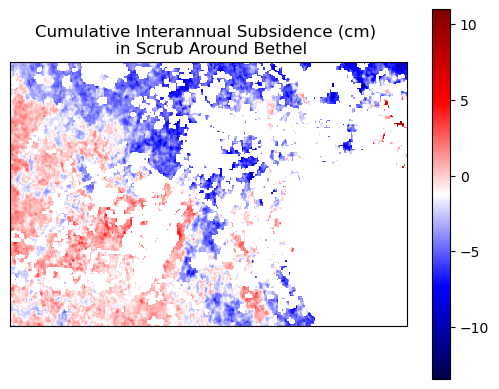

In [23]:
# Plot ground deformation within scrubland around Bethel

plt.imshow(cumulative_scrub[70:270,50:350],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Cumulative Interannual Subsidence (cm) \n in Scrub Around Bethel' )
plt.show()

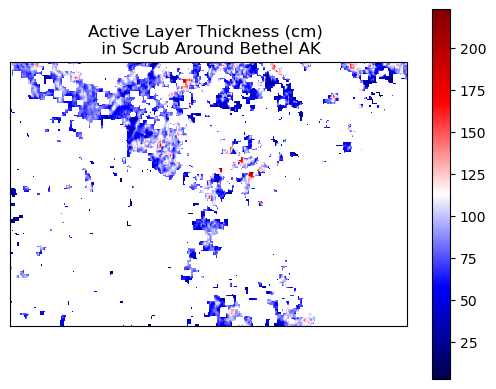

In [24]:
# Plot active layer thickness within scrubland around Bethel

plt.imshow(alt_scrub[70:270,50:350],cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Active Layer Thickness (cm) \n in Scrub Around Bethel AK')
plt.show()

In [25]:
# Create copies of each layer and select pixels within areas marked by scrubland

def_wetlands = np.copy(def_copy)
alt_wetlands = np.copy(alt_copy)
cumulative_sub_wetlands = np.copy(cumulative_sub_copy)

for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v!=90 and v!=95:
            def_wetlands[index][i]=np.nan
            alt_wetlands[index][i]=np.nan
            cumulative_sub_wetlands[index][i]=np.nan

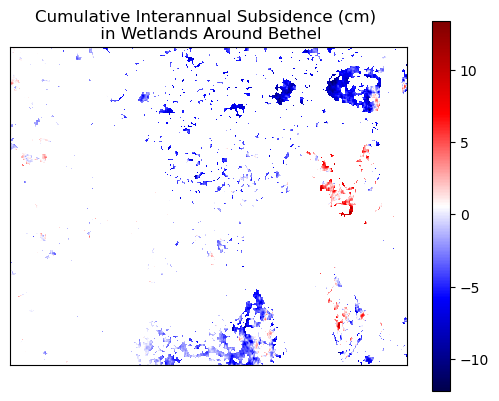

In [26]:
# Plot cumulative subsidence in wetlands around Bethel

plt.imshow(cumulative_sub_wetlands,cmap='seismic')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Cumulative Interannual Subsidence (cm) \n in Wetlands Around Bethel' )
plt.show()

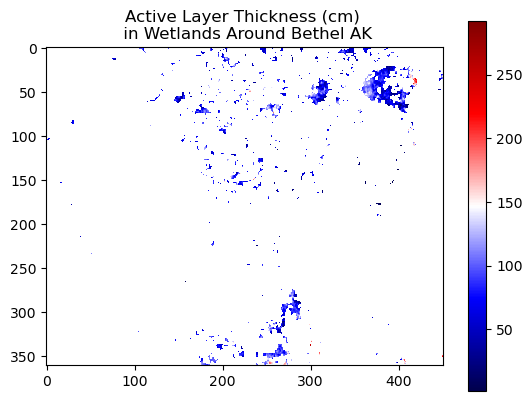

In [27]:
# Plot active layer thickness in wetlands around Bethel

plt.imshow(alt_wetlands,cmap='seismic')
plt.title('Active Layer Thickness (cm) \n in Wetlands Around Bethel AK')
plt.colorbar()
plt.show()

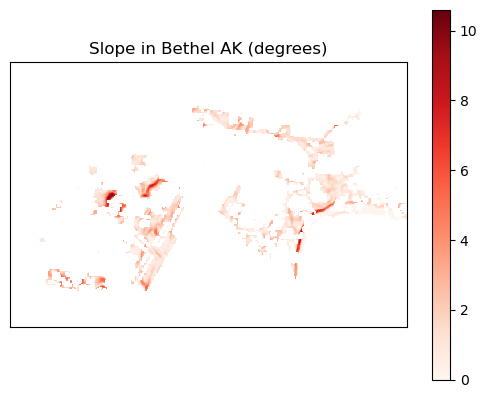

In [28]:
# Extract slope pixels within Bethel urban areas

slope_urban = np.copy(slope_arr)
for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v<21 or v>24:
            slope_urban[index][i]=np.nan     
            
# Plot slope within Bethel urban areas 

plt.imshow(slope_urban[70:270,50:350],cmap='Reds')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Slope in Bethel AK (degrees)')
plt.show()

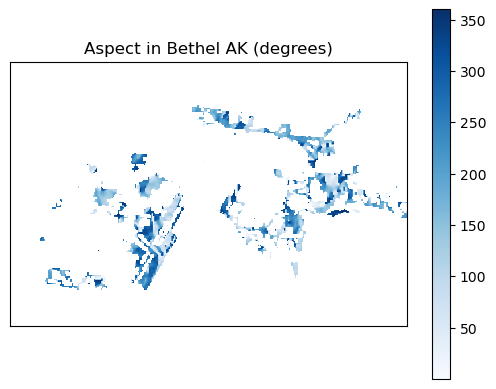

In [29]:
# Extract and plot aspect pixels within Bethel urban areas

aspect_urban = aspect_arr
for index,value in enumerate(lc_arr):
    for i,v in enumerate(lc_arr[index]):
        if v<21 or v>24:
            aspect_urban[index][i]=np.nan  
aspect_copy = np.where(aspect_urban == -9999, np.nan, aspect_urban)
plt.xticks([])
plt.yticks([])
plt.imshow(aspect_copy[70:270,50:350],cmap='Blues')
plt.title('Aspect in Bethel AK (degrees)')
plt.colorbar()
plt.show()

## Calculating Statistics Per Land Cover Type

In [30]:
# Create dictionary with land cover id as key and types as value

numbers = [11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95]
labels = ['Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, Low Intensity','Developed, Medium Intensity',
          'Developed, High Intensity','Barren Land','Deciduous Forest','Evergreen Forest','Mixed Forest','Dwarf Scrub','Shrub/Scrub',
          'Grassland/Herbaceous','Sedge/Herbaceous','Lichens','Moss','Pasture/Hay','Cultivated Crops','Woody Wetlands',
          'Emergent Herbaceous Wetlands']
zipped = dict(zip(numbers,labels))
zipped

{11: 'Open Water',
 12: 'Perennial Ice/Snow',
 21: 'Developed, Open Space',
 22: 'Developed, Low Intensity',
 23: 'Developed, Medium Intensity',
 24: 'Developed, High Intensity',
 31: 'Barren Land',
 41: 'Deciduous Forest',
 42: 'Evergreen Forest',
 43: 'Mixed Forest',
 51: 'Dwarf Scrub',
 52: 'Shrub/Scrub',
 71: 'Grassland/Herbaceous',
 72: 'Sedge/Herbaceous',
 73: 'Lichens',
 74: 'Moss',
 81: 'Pasture/Hay',
 82: 'Cultivated Crops',
 90: 'Woody Wetlands',
 95: 'Emergent Herbaceous Wetlands'}

In [31]:
# Remove land cover types that are not within the defined area of interest

unique_land = np.unique(lc_arr)
list_keys = list(zipped.keys())
for x in list_keys:
    if x not in unique_land:
        zipped.pop(x)

In [40]:
# Calculate statistics for all layers by land cover type

standard_dev = dict()
unique = np.unique(lc_arr)
layers = [alt_copy,slope_copy,thaw_copy,thaw_rate_copy,cumulative_sub_copy]

layer_labels = ['Active Layer Thickness','Slope','Thaw Subsidence','Thaw Rate','Cumulative Subsidence']
total_stats={}
for x,z in zip(layers,layer_labels):
    land_cover_stats = {}
    for y in unique:
        if y!=0:
            selection = np.copy(x)
            value = lc_arr==y
            selection[value==False]=np.nan
            row_mean = np.nanmean(selection)
            row_std = np.nanstd(selection)
            land_cover_stats[y]=row_mean
            standard_dev[y]=row_std
    total_stats[z]=land_cover_stats

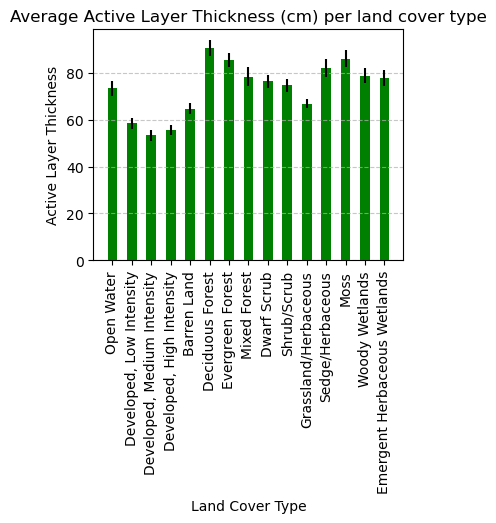

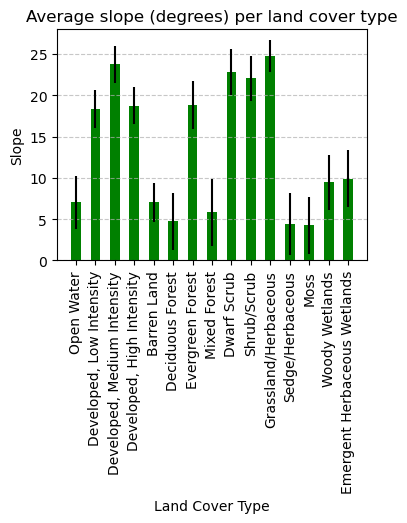

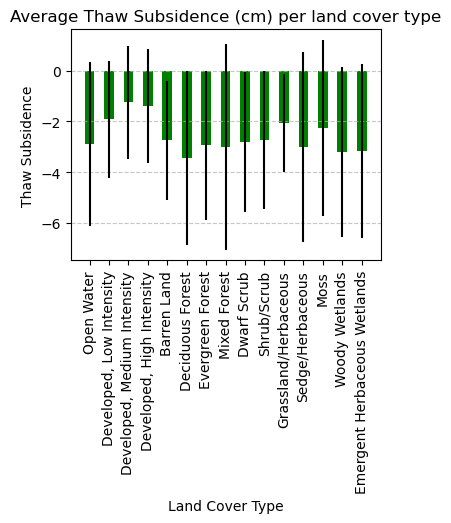

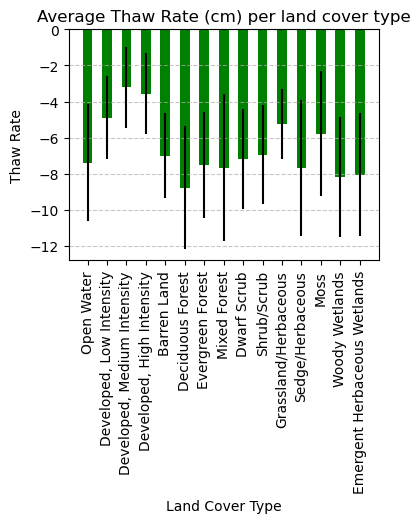

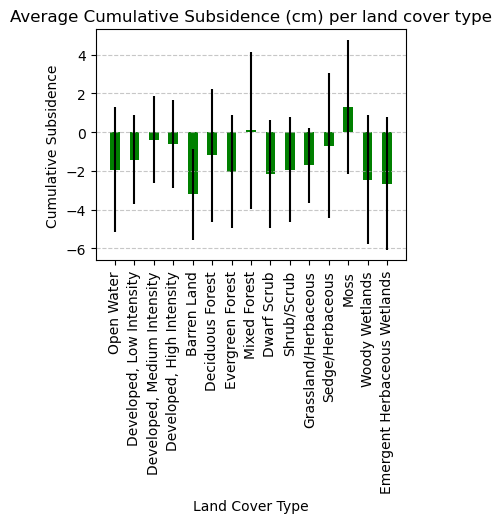

In [41]:
# Plot statistics for all layers by land cover type

for layer,stats in total_stats.items():
    x_values = []
    each_stat = total_stats[layer]
    for x in each_stat.keys():
        if x not in x_values:
            x_values.append(x)
    list_keys = list(zipped.keys())
    for x in list_keys:
        if x not in x_values:
            zipped.pop(x)
    labels = list(zipped.values())
    plt.figure(figsize=(4, 3))
    x_positions = np.arange(len(labels))  # Evenly spaced positions
    plt.bar(x_positions,list(each_stat.values()),yerr=standard_dev.values(),width=0.5,color='green')
    plt.xticks(x_positions,labels,rotation='vertical')
    if layer=='Slope':
        plt.title('Average slope (degrees) per land cover type')
    else: 
        plt.title(f"Average {layer} (cm) per land cover type")
    plt.xlabel('Land Cover Type')
    plt.ylabel(layer)
    plt.grid(axis='y', linestyle='--', alpha=0.7)




In [42]:
# Create table with average values for each layer

mean_value_df = pd.DataFrame(columns=['land_cover_type','land_cover_id','deformation','active_layer_thickness','slope',
                            'thaw_subsidence','thaw_rate','cumulative_subsidence'])
layer_labels = ['Active Layer Thickness','Slope','Thaw Subsidence','Thaw Rate','Cumulative Subsidence']

mean_value_df.land_cover_type = list(zipped.values())
mean_value_df.land_cover_id = x_values
mean_value_df.active_layer_thickness = total_stats['Active Layer Thickness'].values()
mean_value_df.slope = total_stats['Slope'].values()
mean_value_df.thaw_subsidence = total_stats['Thaw Subsidence'].values()
mean_value_df.thaw_rate = total_stats['Thaw Rate'].values()
mean_value_df.cumulative_subsidence = total_stats['Cumulative Subsidence'].values()
mean_value_df

,land_cover_type,land_cover_id,deformation,active_layer_thickness,slope,thaw_subsidence,thaw_rate,cumulative_subsidence
0,Open Water,11,NaN,73.502769,7.042154,-2.894603,-7.378006,-1.950102
1,"Developed, Low Intensity",22,NaN,58.507398,18.295904,-1.917259,-4.886868,-1.424707
2,"Developed, Medium Intensity",23,NaN,53.287581,23.752590,-1.260061,-3.211749,-0.389821
3,"Developed, High Intensity",24,NaN,55.539024,18.755381,-1.396647,-3.559889,-0.620554
4,Barren Land,31,NaN,64.773462,7.013358,-2.748940,-7.006726,-3.215105
5,Deciduous Forest,41,NaN,90.466934,4.732948,-3.440119,-8.768461,-1.206963
6,Evergreen Forest,42,NaN,85.481806,18.809284,-2.943807,-7.503418,-2.036549
7,Mixed Forest,43,NaN,78.430052,5.843713,-3.007571,-7.665944,0.101997
8,Dwarf Scrub,51,NaN,76.411941,22.826393,-2.818624,-7.184341,-2.163859
9,Shrub/Scrub,52,NaN,74.626437,22.044159,-2.721827,-6.937617,-1.943791


In [43]:
# Sort by active layer thickness ascending
# This table shows the land cover types with the largest average active layer thickness 

alt_df = mean_value_df.sort_values('active_layer_thickness',ascending=False)
alt_df_copy = pd.DataFrame(alt_df,columns=['land_cover_type','active_layer_thickness'])
alt_df_copy.head()


,land_cover_type,active_layer_thickness
5,Deciduous Forest,90.466934
12,Moss,86.130880
6,Evergreen Forest,85.481806
11,Sedge/Herbaceous,81.973685
13,Woody Wetlands,78.873865


In [44]:
# Sort by thaw subsidence ascending
# This table shows the land cover types with the largest average thaw subsidence 

thaw_sub_df = mean_value_df.sort_values('thaw_subsidence',ascending=True)
thaw_sub_df_copy = pd.DataFrame(thaw_sub_df,columns=['land_cover_type','thaw_subsidence'])
thaw_sub_df_copy.head()


,land_cover_type,thaw_subsidence
5,Deciduous Forest,-3.440119
13,Woody Wetlands,-3.205543
14,Emergent Herbaceous Wetlands,-3.155151
11,Sedge/Herbaceous,-3.012908
7,Mixed Forest,-3.007571


In [45]:
# Sort by cumulative subsidence ascending
# This table shows the land cover types with the largest average cumulative 
# interannual subsidence (2018-2021)

cumulative_sub_df = mean_value_df.sort_values('cumulative_subsidence',ascending=True)
cumulative_sub_df_copy = pd.DataFrame(cumulative_sub_df,columns=['land_cover_type','cumulative_subsidence'])
cumulative_sub_df_copy.head()


,land_cover_type,cumulative_subsidence
4,Barren Land,-3.215105
14,Emergent Herbaceous Wetlands,-2.655331
13,Woody Wetlands,-2.466970
8,Dwarf Scrub,-2.163859
6,Evergreen Forest,-2.036549


In [46]:
# Sort by max thaw rate ascending
# This table shows the land cover types with the largest average max thaw rate per year

thaw_rate_df = mean_value_df.sort_values('thaw_rate',ascending=True)
thaw_rate_df_copy = pd.DataFrame(thaw_rate_df,columns=['land_cover_type','thaw_rate'])
thaw_rate_df_copy.head()

,land_cover_type,thaw_rate
5,Deciduous Forest,-8.768461
13,Woody Wetlands,-8.170553
14,Emergent Herbaceous Wetlands,-8.042110
11,Sedge/Herbaceous,-7.679550
7,Mixed Forest,-7.665944


In [47]:
# Calculate average values for slopes greater than certain threshold

high_slope_means = {}
layers = [lc_arr,def_copy,alt_copy,thaw_copy,thaw_rate_copy,cumulative_sub_copy]
layer_labels = ['Land Cover','Deformation (cm)','Active Layer Thickness (cm)','Average Thaw Subsidence (cm)','Max Thaw Rate (cm/yr)','Cumulative Thaw Subsidence (cm)']

high_slope = np.nanpercentile(slope_copy,75)
for layer,label in zip(layers,layer_labels):
    slope_indices = np.where(slope_copy>high_slope)
    avg = np.nanmean(layer[slope_indices])
    high_slope_means[label]=avg

# Calculate average cumulative subsidence for slopes less than certain threshold

low_slope_means = {}
layers = [lc_arr,def_copy,alt_copy,thaw_copy,thaw_rate_copy,cumulative_sub_copy]
layer_labels = ['Land Cover','Deformation (cm)','Active Layer Thickness (cm)','Average Thaw Subsidence (cm)','Max Thaw Rate (cm/yr)','Cumulative Thaw Subsidence (cm)']

low_slope = np.nanpercentile(slope_copy,25)
for layer,label in zip(layers,layer_labels):
    slope_indices = np.where(slope_copy>low_slope)
    avg = np.nanmean(layer[slope_indices])
    low_slope_means[label]=avg

high_slope_values = [high_slope_means[label] for label in layer_labels]
low_slope_values = [low_slope_means[label] for label in layer_labels]

slope_means = pd.DataFrame({'Layer':layer_labels,'High Slope (>75th)': high_slope_values, 'Low Slope (<25th)': low_slope_values})
slope_means

,Layer,High Slope (>75th),Low Slope (<25th)
0,Land Cover,50.893614,54.846579
1,Deformation (cm),-0.007737,-0.013203
2,Active Layer Thickness (cm),69.817207,76.162802
3,Average Thaw Subsidence (cm),-2.107423,-2.794296
4,Max Thaw Rate (cm/yr),-5.371575,-7.122331
5,Cumulative Thaw Subsidence (cm),-0.643532,-2.154225
